In [49]:
import pickle
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional

from IPython.display import HTML
import jax
import matplotlib
from ipywidgets import widgets
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray

grid_node_features = None
mesh_graph_structure = None
updated_latent_mesh_nodes = None
predictions = None
_mesh_nodes_lat = None
_mesh_nodes_lon = None


In [110]:
with open('../graphcast-data/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)

# -1 days +18:00:00    00:00:00
input_2m = inputs["2m_temperature"]
# 按照time维度拆分数据
time_step_1 = input_2m[:, 0, :, :]  # 第一个时间步的数据
time_step_2 = input_2m[:, 1, :, :]  # 第二个时间步的数据
time_step_1[0]

<xarray.DataArray '2m_temperature' (lat: 721, lon: 1440)>
array([[-1.28125, -1.28125, -1.28125, ..., -1.28125, -1.28125, -1.28125],
       [-1.28906, -1.28906, -1.28906, ..., -1.28906, -1.28906, -1.28906],
       [-1.29688, -1.29688, -1.30469, ..., -1.29688, -1.29688, -1.29688],
       ...,
       [-1.34375, -1.34375, -1.34375, ..., -1.34375, -1.34375, -1.34375],
       [-1.36719, -1.36719, -1.36719, ..., -1.36719, -1.36719, -1.36719],
       [-1.39062, -1.39062, -1.39062, ..., -1.39062, -1.39062, -1.39062]],
      dtype=bfloat16)
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
    time     timedelta64[ns] -1 days +18:00:00

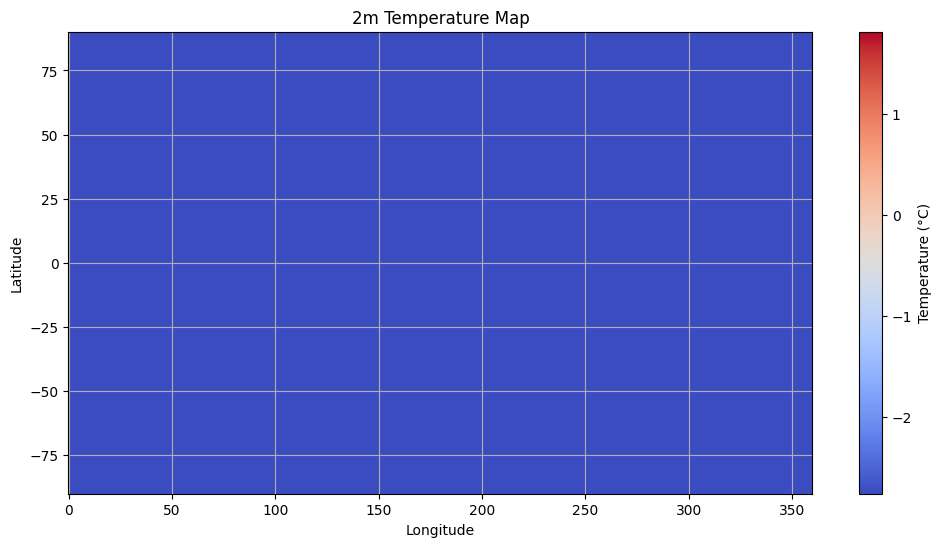

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经有了以下数据：
# _mesh_nodes_lon 和 _mesh_nodes_lat 是经纬度数据
# temperature_data 是 (lat, lon) 形状的温度数据数组

# 获取经纬度
latitudes = inputs['lat'].values  # 纬度 (721,)
longitudes = inputs['lon'].values  # 经度 (1440,)
temperature_data = time_step_2[0]

# 使用 np.meshgrid 生成经纬度网格
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制温度数据
# 使用 pcolormesh 绘制带颜色的网格图，temperature_data 对应颜色
mesh = plt.pcolormesh(lon_grid, lat_grid, temperature_data, cmap='coolwarm', shading='auto')

# 添加色条
plt.colorbar(mesh, label='Temperature (°C)')

# 添加标题和坐标轴标签
plt.title('2m Temperature Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 添加经纬度网格线
plt.grid(True)

# 显示图像
plt.show()


In [99]:
with open('../graphcast-data/forcings.pkl', 'rb') as f:
    forcings = pickle.load(f)

forcings

<xarray.Dataset>
Dimensions:                       (time: 1, batch: 1, lon: 1440, lat: 721)
Coordinates:
  * time                          (time) timedelta64[ns] 06:00:00
  * lon                           (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                           (lat) float32 -90.0 -89.75 ... 89.75 90.0
Dimensions without coordinates: batch
Data variables:
    day_progress_cos              (time, batch, lon) bfloat16 xarray_jax.JaxA...
    day_progress_sin              (time, batch, lon) bfloat16 xarray_jax.JaxA...
    toa_incident_solar_radiation  (time, batch, lat, lon) bfloat16 xarray_jax...
    year_progress_cos             (time, batch) bfloat16 xarray_jax.JaxArrayW...
    year_progress_sin             (time, batch) bfloat16 xarray_jax.JaxArrayW...

In [50]:
with open('../graphcast-data/_mesh_nodes_lat.pkl', 'rb') as f:
    _mesh_nodes_lat = pickle.load(f)
with open('../graphcast-data/_mesh_nodes_lon.pkl', 'rb') as f:
    _mesh_nodes_lon = pickle.load(f)
 
print((_mesh_nodes_lat))
print((_mesh_nodes_lon))

[10.812325 52.62263  52.62263  ... 19.377457 20.104012 18.93003 ]
[ 60.      120.        0.      ... 142.95705 141.96313 141.79604]


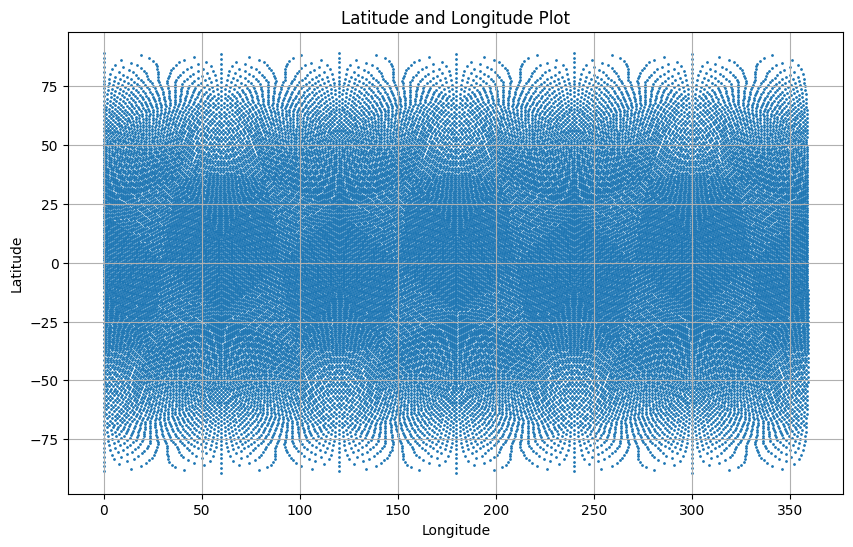

In [93]:
import matplotlib.pyplot as plt

# 创建一个新图
plt.figure(figsize=(10, 6))

# 绘制散点图，经纬度作为x和y坐标
plt.scatter(_mesh_nodes_lon, _mesh_nodes_lat, s=1)

# 设置图表标题和坐标轴标签
plt.title('Latitude and Longitude Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 显示网格
plt.grid(True)

# 显示图表
plt.show()

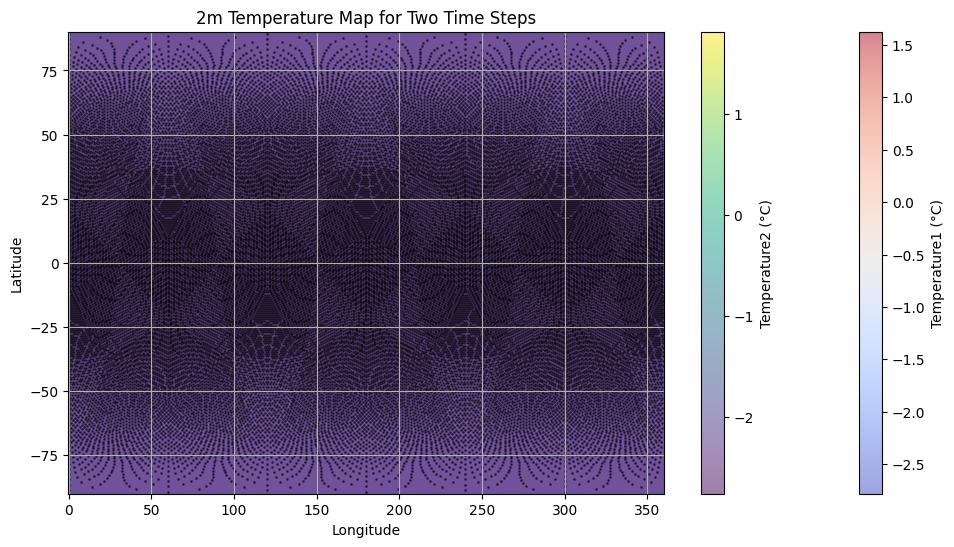

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# 假设数据形状为 (time, lat, lon)，比如 (2, 721, 1440)
# 获取经纬度和温度数据
latitudes = inputs['lat'].values  # 纬度 (721,)
longitudes = inputs['lon'].values  # 经度 (1440,)
# print(inputs['2m_temperature'])
temperature_data_time1 = inputs['2m_temperature'].values[0, 0]  # 第一个时间步的温度数据 (721, 1440)
temperature_data_time2 = inputs['2m_temperature'].values[0, 1]  # 第二个时间步的温度数据 (721, 1440)

# 使用 np.meshgrid 生成经纬度网格
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制第一个时间步的温度图
mesh1 = plt.pcolormesh(lon_grid, lat_grid, temperature_data_time1, cmap='coolwarm', shading='auto', alpha=0.5)

# 绘制第二个时间步的温度图（与第一个温度图重叠）
mesh2 = plt.pcolormesh(lon_grid, lat_grid, temperature_data_time2, cmap='viridis', shading='auto', alpha=0.5)

# 在图上添加散点图
plt.scatter(_mesh_nodes_lon, _mesh_nodes_lat, s=1, c='black', label='Mesh Nodes', alpha=0.5)

# 添加色条
plt.colorbar(mesh1, label='Temperature1 (°C)')
plt.colorbar(mesh2, label='Temperature2 (°C)')

# 添加标题和坐标轴标签
plt.title('2m Temperature Map for Two Time Steps')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 添加经纬度网格线
plt.grid(True)

# 显示图像
plt.show()


In [ ]:
with open('../graphcast-data/grid_node_features.pkl', 'rb') as f:
    grid_node_features = pickle.load(f)
    
# channels 471 是怎么计算出来的？
# 37 levels * 2 time * 18 variables = 1332
# 466(每个变量的channels总和) + 5
# ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'day_progress_cos', 'day_progress_sin', 'geopotential', 'geopotential_at_surface', 'land_sea_mask', 'mean_sea_level_pressure', 'specific_humidity', 'temperature', 'toa_incident_solar_radiation', 'total_precipitation_6hr', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity', 'year_progress_cos', 'year_progress_sin']
# day_progress_cos, day_progress_sin, toa_incident_solar_radiation, year_progress_cos, year_progress_sin
grid_node_features

Array([[[0.246094, 0.109863, -0.131836, ..., 0.628906, 1.39844,
         0.0246582]],

       [[0.246094, 0.109863, -0.131836, ..., 0.628906, 1.39844,
         0.0246582]],

       [[0.246094, 0.109863, -0.131836, ..., 0.628906, 1.39844,
         0.0246582]],

       ...,

       [[0.0216064, -0.0375977, -0.0368652, ..., -0.746094, 1.39844,
         0.0246582]],

       [[0.0216064, -0.0375977, -0.0368652, ..., -0.746094, 1.39844,
         0.0246582]],

       [[0.0216064, -0.0375977, -0.0368652, ..., -0.746094, 1.39844,
         0.0246582]]], dtype=bfloat16)

In [52]:
# import matplotlib.pyplot as plt

# # 假设温度特征是第一个特征（索引0）
# temperature_feature = grid_node_features[:, 0, 0]

# # 绘制直方图
# plt.hist(temperature_feature, bins=50)
# plt.title('Temperature Feature Distribution')
# plt.xlabel('Temperature')
# plt.ylabel('Frequency')
# plt.show()

In [75]:
with open('../graphcast-data/mesh_graph_structure.pkl', 'rb') as f:
    mesh_graph_structure = pickle.load(f)

print(mesh_graph_structure)    
# node_features是经纬度转球坐标，计算cos和sin得到  get_graph_spatial_features
# edge_features是球坐标计算距离得到
# mesh_graph_structure.nodes["mesh_nodes"]


TypedGraph(context=Context(n_graph=array([1]), features=()), nodes={'mesh_nodes': NodeSet(n_node=array([40962]), features=array([[ 0.18759258,  0.49999997,  0.86602545],
       [ 0.7946544 , -0.50000006,  0.8660254 ],
       [ 0.7946544 ,  1.        ,  0.        ],
       ...,
       [ 0.33179   , -0.7981841 ,  0.6024136 ],
       [ 0.34372544, -0.7876144 ,  0.61616844],
       [ 0.32441327, -0.7858141 ,  0.61846274]], dtype=float32))}, edges={EdgeSetKey(name='mesh', node_sets=('mesh_nodes', 'mesh_nodes')): EdgeSet(n_edge=array([327660]), indices=EdgesIndices(senders=array([    0,     0,     8, ..., 40961, 10239, 40959], dtype=int32), receivers=array([    1,     6,     0, ..., 40960, 40959, 40960], dtype=int32)), features=array([[ 9.99999412e-01, -5.25730760e-01, -8.09016584e-01,
        -2.62865287e-01],
       [ 9.99999525e-01, -5.25730840e-01, -8.09016591e-01,
         2.62865535e-01],
       [ 9.99999549e-01, -5.25730938e-01, -8.09016600e-01,
        -2.62865402e-01],
       ...,
 

In [54]:
with open('../graphcast-data/updated_latent_mesh_nodes.pkl', 'rb') as f:
    updated_latent_mesh_nodes = pickle.load(f)

updated_latent_mesh_nodes.shape

(40962, 1, 512)

In [85]:
with open('../graphcast-data/prediction.pkl', 'rb') as f:
    predictions = pickle.load(f)

print(predictions)

<xarray.Dataset>
Dimensions:                  (lon: 1440, lat: 721, time: 1, batch: 1, level: 37)
Coordinates:
  * lon                      (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * lat                      (lat) float32 -90.0 -89.75 -89.5 ... 89.75 90.0
  * time                     (time) timedelta64[ns] 06:00:00
  * level                    (level) int32 1 2 3 5 7 10 ... 900 925 950 975 1000
Dimensions without coordinates: batch
Data variables:
    10m_u_component_of_wind  (batch, time, lat, lon) bfloat16 xarray_jax.JaxA...
    10m_v_component_of_wind  (batch, time, lat, lon) bfloat16 xarray_jax.JaxA...
    2m_temperature           (batch, time, lat, lon) bfloat16 xarray_jax.JaxA...
    geopotential             (batch, time, level, lat, lon) bfloat16 xarray_j...
    mean_sea_level_pressure  (batch, time, lat, lon) bfloat16 xarray_jax.JaxA...
    specific_humidity        (batch, time, level, lat, lon) bfloat16 xarray_j...
    temperature              (batch, time, level, la

In [60]:
# @title 载入绘图函数
def select(
    data: xarray.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xarray.Dataset:
  data = data[variable]
  if "batch" in data.dims:
    data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  if level is not None and "level" in data.coords:
    data = data.sel(level=level)
  return data

def scale(
    data: xarray.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:
    
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xarray.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:
  print("plot_data", data)
  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)
  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()

  print(data.items())
  
  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    images.append(im)
    
  plt.show()
  return

  def update(frame):
    if "time" in first_data.dims:
      td = datetime.timedelta(microseconds=first_data["time"][frame].item() / 1000)
      figure.suptitle(f"{fig_title}, {td}", fontsize=16)
    else:
      figure.suptitle(fig_title, fontsize=16)
    for im, (plot_data, norm, cmap) in zip(images, data.values()):
      im.set_data(plot_data.isel(time=frame, missing_dims="ignore"))

  ani = animation.FuncAnimation(
      fig=figure, func=update, frames=max_steps, interval=250)
  plt.close(figure.number)
  return HTML(ani.to_jshtml())


In [57]:
import xarray as xr
import numpy as np

# 创建一个二维数组，其中包含每个网格点的经纬度信息
# 每一行代表一个网格点，第一列是经度，第二列是纬度
mesh_coords = np.column_stack((_mesh_nodes_lon, _mesh_nodes_lat))

# 创建一个 xarray.DataArray 对象来存储经纬度数据
# 这里我们使用 mesh_coords 作为数据源，并且设置 dims 和 coords 参数
mesh_da = xr.DataArray(
    mesh_coords, 
    dims=['num_points', 'coordinates'], 
    coords={'num_points': np.arange(len(mesh_coords))}, 
    attrs={'description': 'Mesh node coordinates'}
)

# 示例数据
data = {
    "Mesh 1": (mesh_da),
}

# 调用函数
plot_data(data=data, fig_title= "Mesh Nodes Geographic Distribution")

ValueError: too many values to unpack (expected 3)

In [58]:
plot_pred_variable = widgets.Dropdown(
    options=predictions.data_vars.keys(),
    value="2m_temperature",
    description="变量")
plot_pred_level = widgets.Dropdown(
    options=predictions.coords["level"].values,
    value=500,
    description="级别")
plot_pred_robust = widgets.Checkbox(value=True, description="鲁棒性")
plot_pred_max_steps = widgets.IntSlider(
    min=1,
    max=predictions.dims["time"],
    value=predictions.dims["time"],
    description="最大步")

widgets.VBox([
    plot_pred_variable,
    plot_pred_level,
    plot_pred_robust,
    plot_pred_max_steps,
    widgets.Label(value="运行下一个单元格，绘制预测结果。重新运行该单元格将清除您的选择。")
])


plot_data {'Predictions': (<xarray.DataArray '2m_temperature' (time: 1, lat: 721, lon: 1440)>
xarray_jax.JaxArrayWrapper(Array([[[-0.12695312, -0.12792969, -0.13085938, ..., -0.13183594,
         -0.13085938, -0.13085938],
        [-0.05444336, -0.05273438, -0.05419922, ..., -0.05761719,
         -0.05224609, -0.05371094],
        [-0.11376953, -0.11572266, -0.11572266, ..., -0.11376953,
         -0.11621094, -0.11621094],
        ...,
        [-0.26367188, -0.25390625, -0.2578125 , ..., -0.26367188,
         -0.25390625, -0.2578125 ],
        [-0.234375  , -0.23144531, -0.22753906, ..., -0.234375  ,
         -0.23242188, -0.23339844],
        [-0.2109375 , -0.21582031, -0.21582031, ..., -0.20898438,
         -0.21191406, -0.21484375]]], dtype=float32))
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) timedelta64[ns] 06:00:00, <matplotlib.colors.No

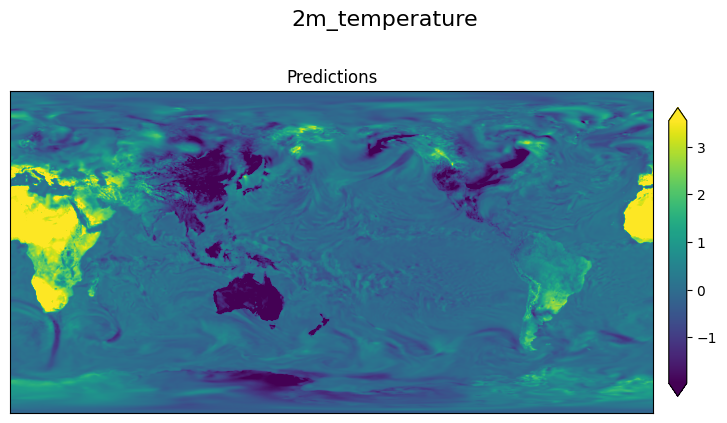

In [61]:
plot_size = 5
plot_max_steps = min(predictions.dims["time"], plot_pred_max_steps.value)

data = {
    # "Targets": scale(select(eval_targets, plot_pred_variable.value, plot_pred_level.value, plot_max_steps), robust=plot_pred_robust.value),
    "Predictions": scale(select(predictions, plot_pred_variable.value, plot_pred_level.value, plot_max_steps).astype("float32"), robust=plot_pred_robust.value),
    # "Diff": scale((select(eval_targets, plot_pred_variable.value, plot_pred_level.value, plot_max_steps) -
    #                     select(predictions, plot_pred_variable.value, plot_pred_level.value, plot_max_steps)),
    #                    robust=plot_pred_robust.value, center=0),
}
fig_title = plot_pred_variable.value
if "level" in predictions[plot_pred_variable.value].coords:
  fig_title += f" at {plot_pred_level.value} hPa"

plot_data(data, fig_title, plot_size, plot_pred_robust.value)